In [1]:
from datasets import load_dataset

data_files = {
    "indosum/dev.04.jsonl",
}

# Muat dataset
dataset = load_dataset("json", data_files=data_files)
print(dataset)

/home/rakhargo/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'],
        num_rows: 750
    })
})


In [2]:
train_data = dataset['train']
print(train_data[0])

# validation_data = dataset['validation']
# print(validation_data[0])

# test_data = dataset['test']
# print(test_data[0])

{'category': 'tajuk utama', 'gold_labels': [[True], [False], [False], [False, False], [True], [False, False], [False], [False], [False], [False], [False], [False, False], [False], [False, False]], 'id': '1519679780-demokrasi-makin-transaksional-ketua-dpr-galau', 'paragraphs': [[['Suara.com', '-', 'Ketua', 'DPR', 'RI', 'Bambang', 'Soesatyo', 'mengungkapkan', 'kegalauannya', 'melihat', 'perkembangan', 'demokrasi', 'di', 'Indonesia', 'yang', 'makin', 'mengarah', 'pada', 'demokrasi', 'transaksional', 'karena', 'berpotensi', 'mengancam', 'independensi', 'bangsa', 'Indonesia', '.']], [['Bambang', 'Soesatyo', 'mengatakan', 'hal', 'itu', 'dalam', 'sambutannya', 'ketika', 'menghadiri', 'acara', 'peresmian', 'Grha', 'Suara', 'Muhammadiyah', ',', 'di', 'Yogyakarta', ',', 'Minggu', '(', '25', '/', '2', '/', '2018', ')', ',', 'seperti', 'dikutip', 'melalui', 'siaran', 'persnya', '.']], [['Hadir', 'dalam', 'acara', 'tersebut', 'antara', 'lain', ',', 'Ketua', 'Umum', 'PP', 'Muhammadiyah', 'Haedar', '

In [3]:
def join_data(dataset):
    documents = []
    summaries = []
    for item in dataset:
        document = [" ".join(sent) for para in item["paragraphs"] for sent in para]
        summary = " ".join([" ".join(sent) for sent in item["summary"]])
        
        documents.append(document)
        summaries.append(summary)
    
    return documents, summaries

# Memproses data
train_docs, train_summaries = join_data(train_data)

In [4]:
print(train_docs[0])
print(train_summaries[0])
len(train_docs)

['Suara.com - Ketua DPR RI Bambang Soesatyo mengungkapkan kegalauannya melihat perkembangan demokrasi di Indonesia yang makin mengarah pada demokrasi transaksional karena berpotensi mengancam independensi bangsa Indonesia .', 'Bambang Soesatyo mengatakan hal itu dalam sambutannya ketika menghadiri acara peresmian Grha Suara Muhammadiyah , di Yogyakarta , Minggu ( 25 / 2 / 2018 ) , seperti dikutip melalui siaran persnya .', 'Hadir dalam acara tersebut antara lain , Ketua Umum PP Muhammadiyah Haedar Nashir , mantan Ketua Umum PP Muhammadiyah Buya Ahmad Syafii Maarif , Menkominfo Rudiantara , Mendikbud Muhadjir Effendy , anggota Fraksi Partai Golkar DPR RI Mukhamad Misbakhun , anggota Fraksi Nasdem DPR RI Ahmad Syahroni , Ketua Umum PP Aisyah Nurjanah , Kapolda DI Yogyakarta Brigjen Pol Ahmad Dofiri , serta mantan Ketua KPK Busyro Muqoddas .', '" Saya secara khusus meminta kepada Muhammadiyah untuk mengkaji kembali sistem pemilihan langsung dalam demokrasi kita , terutama dalam pilkada .'

750

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs + train_summaries)
vocab_size = len(tokenizer.word_index) + 1

# Mengubah teks menjadi sequence
X = tokenizer.texts_to_sequences(train_docs)
y = tokenizer.texts_to_sequences(train_summaries)

max_length = max(max(len(seq) for seq in X), max(len(seq) for seq in y))

X_pad = pad_sequences(X, maxlen=max_length, padding='post')
y_pad = pad_sequences(y, maxlen=max_length, padding='post')

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=42)

2024-11-21 12:10:45.211910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732165845.229201  166361 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732165845.235208  166361 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 12:10:45.254994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
print(vocab_size)

22475


In [6]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# nltk.download('punkt')

In [7]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1732165847.593174  166361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
import os

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

X_train = X_pad[:, :-1] 
y_train = y_pad[:, 1:]

history_lstm = model.fit(X_train, y_train, epochs=500, batch_size=16)

Epoch 1/500


I0000 00:00:1732165849.450915  166461 cuda_dnn.cc:529] Loaded cuDNN version 90300


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2911 - loss: 9.7622
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3242 - loss: 8.0053
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3232 - loss: 6.9520
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3211 - loss: 6.3457
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.3243 - loss: 6.0212
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3228 - loss: 5.9504
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3230 - loss: 5.9229
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3205 - loss: 5.9345
Epoch 9/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3225 - loss: 5.9005
Epoch 10/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3182 - loss: 5.9224
Epoch 11/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3234 - loss: 5.8767
Epoch 12/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy

In [9]:
model.save("lstmModel.keras")

In [10]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(Dense(vocab_size, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
import os

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

X_train = X_pad[:, :-1]
y_train = y_pad[:, 1:]

history_simplernn = model2.fit(X_train, y_train, epochs=500, batch_size=16)

Epoch 1/500


I0000 00:00:1732166946.288589  166456 service.cc:148] XLA service 0x7f70d00142a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732166946.288688  166456 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-21 12:29:06.328852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1732166946.390764  166456 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-21 12:29:08.046322: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 72 bytes spill stores, 72 bytes spill loads

2024-11-21 12:29:08.373857: I external/local_xla/xla/stream_executor/cuda/cuda_asm

 5/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.4293e-04 - loss: 10.0151

I0000 00:00:1732166953.480438  166456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2125 - loss: 9.7468

W0000 00:00:1732166954.791486  166453 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-21 12:29:16.037408: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 92 bytes spill stores, 92 bytes spill loads

2024-11-21 12:29:16.342932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 296 bytes spill stores, 296 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.2172 - loss: 9.7210
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3227 - loss: 8.0298
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3233 - loss: 7.0532
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3220 - loss: 6.4471
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3200 - loss: 6.0981
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3249 - loss: 5.9697
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3227 - loss: 5.9387
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3264 - loss: 5.8773
Epoch 9/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3236 - loss: 5.8707
Epoch 10/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3251 - loss: 5.8353
Epoch 11/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3203 - loss: 5.8775
Epoch 12/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accurac

In [12]:
model2.save("simplernnModel.keras")

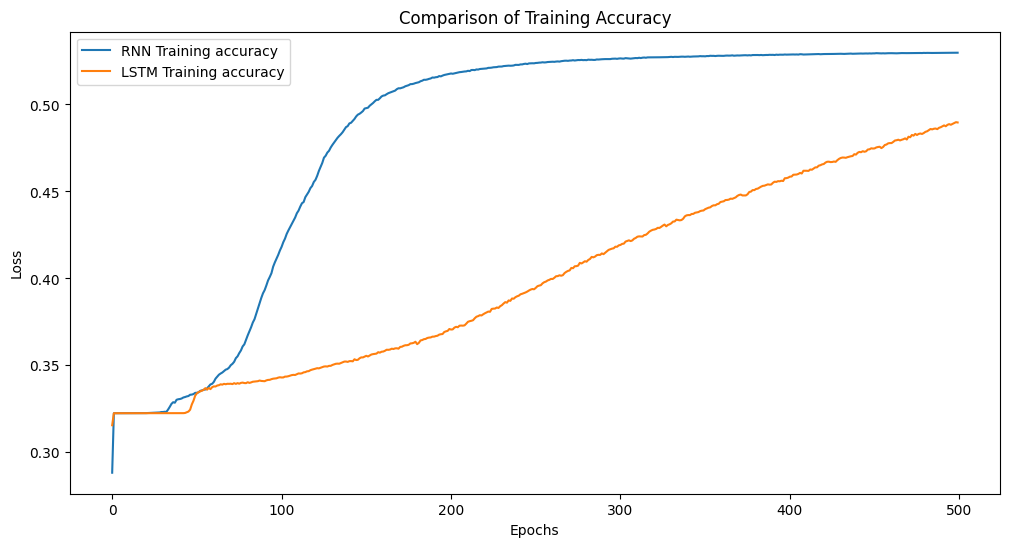

In [17]:
import matplotlib.pyplot as plt

# Data untuk model RNN
accuracy_rnn = history_simplernn.history['accuracy']

# Data untuk model LSTM
accuracy_lstm = history_lstm.history['accuracy']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy_rnn, label='RNN Training accuracy')
plt.plot(accuracy_lstm, label='LSTM Training accuracy')

plt.title('Comparison of Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

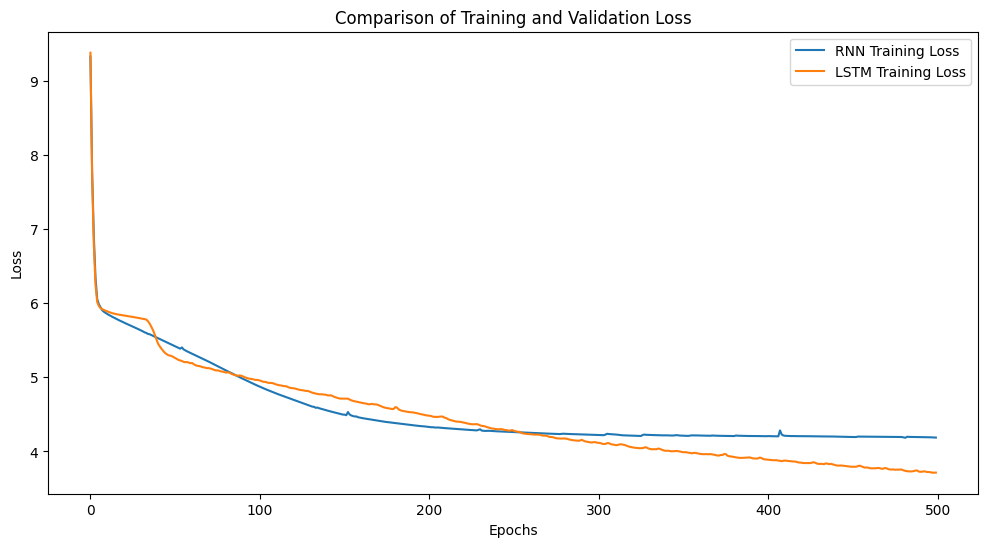

In [ ]:
import matplotlib.pyplot as plt

# Data untuk model RNN
loss_rnn = history_simplernn.history['loss']

# Data untuk model LSTM
loss_lstm = history_lstm.history['loss']

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(loss_rnn, label='RNN Training Loss')
plt.plot(loss_lstm, label='LSTM Training Loss')

plt.title('Comparison of Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
input_test = X_test[0:1]
reference_test = y_test[0]

# Prediksi menggunakan model simplernn
raw_prediction = model.predict(input_test)
predicted_sequence = raw_prediction.argmax(axis=-1)[0]

# Konversi sequence ke teks
def sequence_to_text(sequence, tokenizer):
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_map.get(idx, '') for idx in sequence if idx != 0])

# input_test = sequence_to_text(input_test, tokenizer)
predicted_text = sequence_to_text(predicted_sequence, tokenizer)
reference_text = sequence_to_text(reference_test, tokenizer)

print(f"Reference: {reference_text}")
print(f"Predicted: {predicted_text}")

# Hitung BLEU Score
from nltk.translate.bleu_score import sentence_bleu

reference_tokens = reference_text.split()
predicted_tokens = predicted_text.split()
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)
print(f"BLEU Score: {bleu_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Reference: meski kalah dari thailand di semifinal piala aff u18 pada babak adu penalti dengan skor 3 2 pelatih timnas indonesia u 19 indra sjafri   tetap mengapresiasi perjuangan garuda nusantara di laga tersebut dalam jumpa pers pasca pertandingan indra mengungkapkan bahwa dia mengucapkan terima kasih banyak dan terharu melihat perjuangan para pemain dari babak kedua mulai para pemain sudah berjuang dengan sepuluh orang
Predicted: kalah dari thailand di semifinal piala aff u18 pada babak mi pengapalan dengan skor 3 2 baik timnas indonesia u yang yang di di di di di di di di di di di di di di yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang yang dan dan
BLEU Score: 0.2045


In [ ]:
input_test = X_test[0:1]
reference_test = y_test[0]

# Prediksi menggunakan model simplernn
raw_prediction = model2.predict(input_test)
predicted_sequence = raw_prediction.argmax(axis=-1)[0]

# Konversi sequence ke teks
def sequence_to_text(sequence, tokenizer):
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_map.get(idx, '') for idx in sequence if idx != 0])

predicted_text = sequence_to_text(predicted_sequence, tokenizer)
reference_text = sequence_to_text(reference_test, tokenizer)

print(f"Reference: {reference_text}")
print(f"Predicted: {predicted_text}")

# Hitung BLEU Score
from nltk.translate.bleu_score import sentence_bleu

reference_tokens = reference_text.split()
predicted_tokens = predicted_text.split()
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)
print(f"BLEU Score: {bleu_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Reference: meski kalah dari thailand di semifinal piala aff u18 pada babak adu penalti dengan skor 3 2 pelatih timnas indonesia u 19 indra sjafri   tetap mengapresiasi perjuangan garuda nusantara di laga tersebut dalam jumpa pers pasca pertandingan indra mengungkapkan bahwa dia mengucapkan terima kasih banyak dan terharu melihat perjuangan para pemain dari babak kedua mulai para pemain sudah berjuang dengan sepuluh orang
Predicted: kalah dari thailand di semifinal piala aff u18 pada babak adu penalti dengan skor 3 2 pelatih timnas indonesia u
BLEU Score: 0.1225
